In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from sklearn.linear_model import LogisticRegression, PoissonRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
import joblib

In [2]:
ANC = True
daily_max = False
daily_total = True
min_year_for_analyis = 2011
absolute_min_year = 2011
if daily_max or daily_total:
    mask_threshold = 0
else:
    mask_threshold = 500
mask_threshold = 0

five_day = True
cumulative = True
model_fit_ANC_data = True
model_fit_weather_data = True
poisson=False
if poisson:
    log_y = False
else:
    log_y = True
model_filename = (
    f"best_model_{'ANC' if ANC else 'Reporting'}_prediction_"
    f"{'5_day' if five_day else 'monthly'}_"
    f"{'cumulative' if cumulative else ('max' if daily_max else 'total')}_"
    f"{'poisson' if poisson else 'linear'}_precip.pkl"
)
use_residuals = False
covid_months = range((2020 - min_year_for_analyis)* 12, (2020 - min_year_for_analyis)* 12 + 20) # Bingling's paper: disruption between April 2020 and Dec 2021

print(model_filename)
model_filename_weather_model = (
    f"best_model_weather_"
    f"{'5_day' if five_day else 'monthly'}_"
    f"{'cumulative' if cumulative else ('max' if daily_max else 'total')}_"
    f"{'poisson' if poisson else 'linear'}_precip.pkl"
)
print(model_filename_weather_model)


best_model_ANC_prediction_5_day_cumulative_linear_precip.pkl
best_model_weather_5_day_cumulative_linear_precip.pkl


In [3]:
if ANC:
    monthly_reporting_by_facility = pd.read_csv("/Users/rem76/Desktop/Climate_change_health/Data/monthly_reporting_ANC_by_smaller_facility_lm.csv", index_col=0)
    if daily_max:
        if five_day:
            if cumulative:
                weather_data_historical = pd.read_csv(
                    "/Users/rem76/Desktop/Climate_change_health/Data/Precipitation_data/Historical/daily_total/historical_daily_total_by_facilities_with_ANC_five_day_cumulative.csv",
                    index_col=0)
            else:
                weather_data_historical = pd.read_csv(
                    "/Users/rem76/Desktop/Climate_change_health/Data/Precipitation_data/Historical/daily_total/historical_daily_total_by_facilities_with_ANC_five_day_average.csv",
                    index_col=0)
        else:
            weather_data_historical = pd.read_csv(
                "/Users/rem76/Desktop/Climate_change_health/Data/Precipitation_data/Historical/daily_total/historical_daily_total_by_facility_five_day_cumulative.csv",
                index_col=0)
    elif daily_total:
        if five_day:
            if cumulative:
                weather_data_historical = pd.read_csv(
                        "/Users/rem76/Desktop/Climate_change_health/Data/Precipitation_data/Historical/daily_total/historical_daily_total_by_facilities_with_ANC_five_day_cumulative.csv",
                        index_col=0)
    else:
        weather_data_historical = pd.read_csv(
            "/Users/rem76/Desktop/Climate_change_health/Data/historical_weather_by_smaller_facilities_with_ANC_lm.csv",
            index_col=0)
        print("month")

else:
    monthly_reporting_by_facility = pd.read_csv("/Users/rem76/Desktop/Climate_change_health/Data/monthly_reporting_by_smaller_facility_lm.csv", index_col=0)
    if daily_max:
        weather_data_historical = pd.read_csv(
            "/Users/rem76/Desktop/Climate_change_health/Data/Precipitation_data/Historical/daily_maximum/historical_daily_max_by_facility.csv",
            index_col=0)
    elif daily_total:
        weather_data_historical = pd.read_csv(
            "/Users/rem76/Desktop/Climate_change_health/Data/Precipitation_data/Historical/daily_total/historical_daily_total_by_facility.csv",
            index_col=0)
    else:
        weather_data_historical = pd.read_csv(
            "/Users/rem76/Desktop/Climate_change_health/Data/historical_weather_by_smaller_facility_lm.csv",
            index_col=0)
        print("Month")


In [4]:

def build_model(X, y, poisson=False, log_y=False, X_mask_mm=0):
    epsilon = 1

    if log_y:
        y = np.log(np.clip(y, epsilon, None))  # Log-transform y with clipping for positivity
    mask = (~np.isnan(X).any(axis=1) & ~np.isnan(y) & (X[:, 0] >= X_mask_mm) & (y <= 1e4))
    model = GLM(y[mask], X[mask], family=NegativeBinomial()) if poisson else sm.OLS(y[mask], X[mask])
    model_fit = model.fit()
    return model_fit, model_fit.predict(X[mask]), mask

def create_binary_feature(threshold, weather_data_df, recent_months):
    binary_feature_list = []
    for facility in weather_data_df.columns:
        facility_data = weather_data_df[facility]

        for i in range(len(facility_data)):
            facility_threshold = threshold[i] if hasattr(threshold, "__len__") else threshold

            if i >= recent_months:
                last_x_values = facility_data[i - recent_months:i]
                binary_feature_list.append(1 if (last_x_values > facility_threshold).any() else 0)
            else:
                binary_feature_list.append(np.nan)

    return binary_feature_list

def stepwise_selection(X, y, log_y, poisson, p_value_threshold=0.05):
    included = []
    current_aic = np.inf

    while True:
        changed = False

        # Step 1: Try adding each excluded predictor and select the best one by AIC if significant
        excluded = list(set(range(X.shape[1])) - set(included))
        new_aic = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            subset_X = X[:, included + [new_column]]
            results, _, _ = build_model(subset_X, y, poisson, log_y=log_y, X_mask_mm=mask_threshold)
            if results.pvalues[-1] < p_value_threshold:
                new_aic[new_column] = results.aic

        # Add the predictor with the best AIC if it's better than the current model's AIC
        if not new_aic.empty and new_aic.min() < current_aic:
            best_feature = new_aic.idxmin()
            included.append(best_feature)
            current_aic = new_aic.min()
            changed = True
        print(current_aic)


        # Exit if no changes were made in this iteration
        if not changed:
            break

    return included
#


In [5]:
##############################################################################################
########################## STEP 0: Tidy data ##########################
##############################################################################################

if five_day:# Drop September 2024 
    weather_data_historical = weather_data_historical.drop(weather_data_historical.index[-1:])
else: # drop october for monthly data
    weather_data_historical = weather_data_historical.drop(weather_data_historical.index[-3:])

# Mask COVID-19 months
weather_data_historical.loc[covid_months, :] = np.nan

# Drop September 2024 for reporting
monthly_reporting_by_facility = monthly_reporting_by_facility.drop(monthly_reporting_by_facility.index[-1])

# code if years need to be dropped
weather_data_historical = weather_data_historical.iloc[(min_year_for_analyis-absolute_min_year)*12 :]
monthly_reporting_by_facility = monthly_reporting_by_facility.iloc[(min_year_for_analyis-absolute_min_year)*12:]
# Linear regression
month_range = range(12)
num_facilities = len(weather_data_historical.columns)
year_range = range(min_year_for_analyis, 2025, 1) # year as a fixed effect
year_repeated = [y for y in year_range for _ in range(12)]
year = year_repeated[:-4]
year_flattened = year*len(weather_data_historical.columns) # to get flattened data
month = range(12)
month_repeated = []
for _ in year_range:
    month_repeated.extend(range(1, 13))
month = month_repeated[:-4]
month_flattened = month*len(weather_data_historical.columns)
month_encoded = pd.get_dummies(month_flattened, prefix='month', drop_first=True) # try one-hot-encode

facility_flattened = list(range(len(weather_data_historical.columns))) * len(month)

# Flatten data
weather_data = weather_data_historical.values.flatten()
y = monthly_reporting_by_facility.values.flatten()
if np.nanmin(y) < 1:
     y += 1  # Shift to ensure positivity as taking log
y[y > 1e3] = np.nan

# One-hot encode facilities
facility_encoded = pd.get_dummies(facility_flattened, drop_first=True)



# Prepare additional facility info
if ANC:
    expanded_facility_info = pd.read_csv("/Users/rem76/Desktop/Climate_change_health/Data/expanded_facility_info_by_smaller_facility_lm_with_ANC.csv", index_col=0)
else:
    expanded_facility_info = pd.read_csv("/Users/rem76/Desktop/Climate_change_health/Data/expanded_facility_info_by_smaller_facility_lm.csv", index_col=0)
expanded_facility_info = expanded_facility_info.T.reindex(columns=expanded_facility_info.index)

def repeat_info(info, num_facilities, year_range):
    repeated_info = [i for i in info for _ in range(12) for _ in year_range]
    return repeated_info[:-4 * num_facilities]  # Exclude first final months (Sept - Dec 2024)

zone_info_each_month = repeat_info(expanded_facility_info["Zonename"], num_facilities, year_range)
zone_encoded = pd.get_dummies(zone_info_each_month, drop_first=True)
resid_info_each_month = repeat_info(expanded_facility_info['Resid'], num_facilities, year_range)
resid_encoded = pd.get_dummies(resid_info_each_month, drop_first=True)
owner_info_each_month = repeat_info(expanded_facility_info['A105'], num_facilities, year_range)
owner_encoded = pd.get_dummies(owner_info_each_month, drop_first=True)
ftype_info_each_month = repeat_info(expanded_facility_info['Ftype'], num_facilities, year_range)
ftype_encoded = pd.get_dummies(ftype_info_each_month, drop_first=True)
altitude = [float(x) for x in repeat_info(expanded_facility_info['A109__Altitude'], num_facilities, year_range)]
minimum_distance = [float(x) for x in repeat_info(expanded_facility_info['minimum_distance'], num_facilities, year_range)]

# Lagged weather
lag_1_month = weather_data_historical.shift(1).values.flatten()
lag_2_month = weather_data_historical.shift(2).values.flatten()
lag_3_month = weather_data_historical.shift(3).values.flatten()
lag_4_month = weather_data_historical.shift(4).values.flatten()

altitude = np.array(altitude)
altitude = np.where(altitude < 0, np.nan, altitude)
altitude = list(altitude)



ANC prediction                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.976
Method:                 Least Squares   F-statistic:                              2699.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):                        0.00
Time:                        17:54:09   Log-Likelihood:                         -26382.
No. Observations:               23493   AIC:                                  5.348e+04
Df Residuals:                   23134   BIC:                                  5.638e+04
Df Model:                         359                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_9703/3363565216.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(data_ANC_predictions['Year_Month'], rotation=45, ha='right')
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_9703/3363565216.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(data_ANC_predictions['Year_Month'], rotation=45, ha='right')


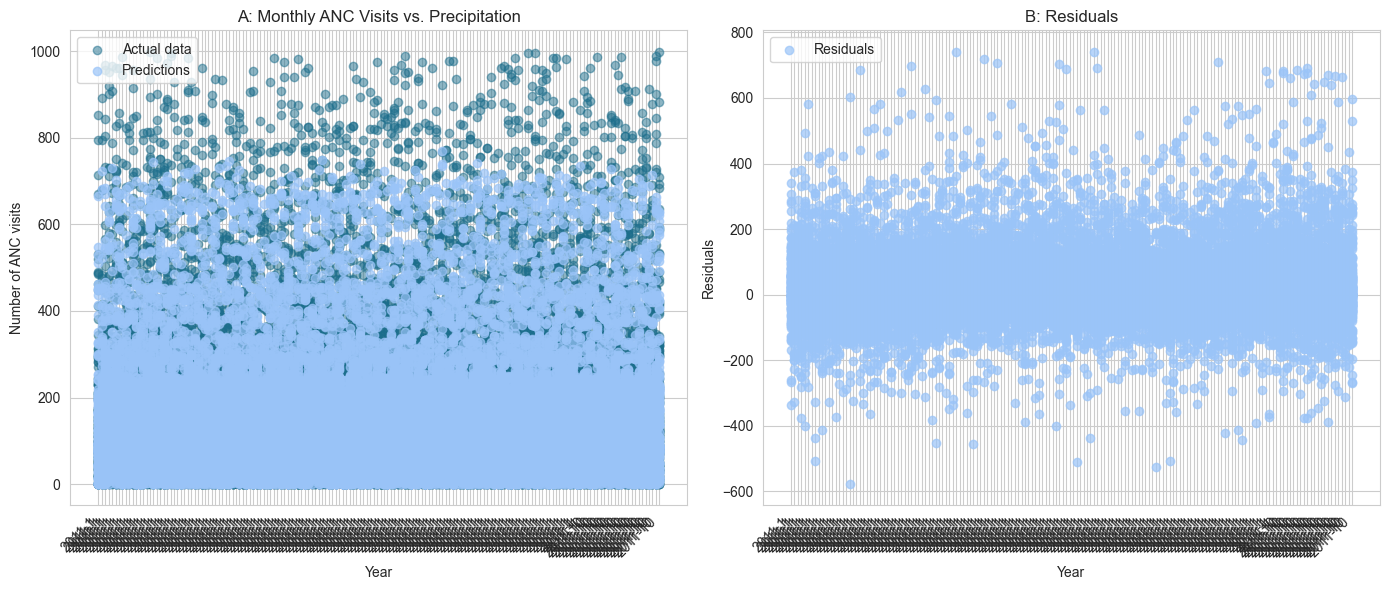

/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_9703/3363565216.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(data_ANC_predictions['Year_Month'], rotation=45, ha='right')
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_9703/3363565216.py:78: RuntimeWarning: invalid value encountered in log
  axs[1].scatter(data_ANC_predictions['Year_Month'], np.log(residuals), color='#9AC4F8', alpha=0.7, label='Residuals')
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_9703/3363565216.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(data_ANC_predictions['Year_Month'], rotation=45, ha='right')


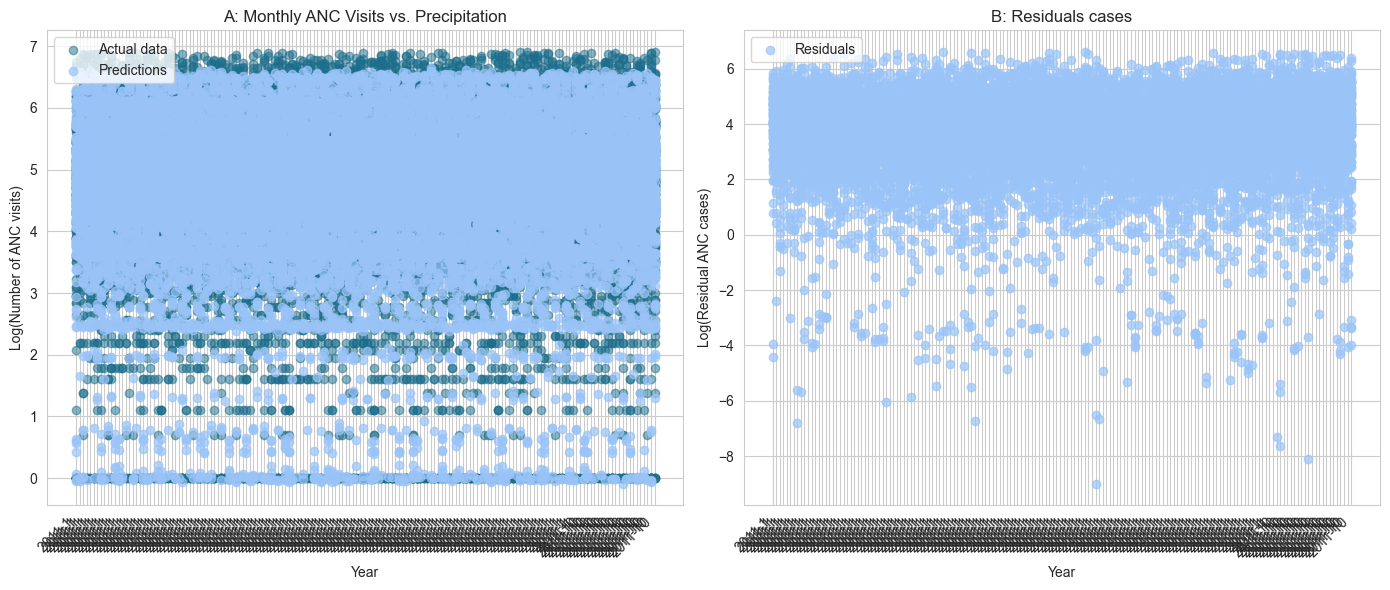

In [6]:

##############################################################################################
########################## STEP 1: GENERATE PREDICTIONS OF ANC DATA ##########################
##############################################################################################

X = np.column_stack([
    year_flattened,
    #month_flattened,
    month_encoded,
    resid_encoded,
    zone_encoded,
    owner_encoded,
    ftype_encoded,
    facility_encoded,
    altitude, 
    minimum_distance
])

results_ANC, y_pred, mask_ANC_data = build_model(X , y, poisson = poisson, log_y=log_y, X_mask_mm=mask_threshold)

if log_y:
    residuals = (y[mask_ANC_data] - np.exp(y_pred))
else:
    residuals = (y[mask_ANC_data] - y_pred)

print("ANC prediction", results_ANC.summary())

# plot
year_month_labels = np.array([f"{y}-{m}" for y, m in zip(year_flattened, month_flattened)])
y_filtered = y[mask_ANC_data]
year_month_labels_filtered = year_month_labels[mask_ANC_data]
if log_y:
    data_ANC_predictions = pd.DataFrame({
        'Year_Month': year_month_labels_filtered,
        'y_filtered': y_filtered,
        'y_pred': np.exp(y_pred),
    })
else:
    data_ANC_predictions = pd.DataFrame({
            'Year_Month': year_month_labels_filtered,
            'y_filtered': y_filtered,
            'y_pred': y_pred,
        })

data_ANC_predictions = data_ANC_predictions.sort_values(by='Year_Month').reset_index(drop=True)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Actual data and predictions
axs[0].scatter(data_ANC_predictions['Year_Month'], data_ANC_predictions['y_filtered'], color='#1C6E8C', alpha=0.5, label='Actual data')
axs[0].scatter(data_ANC_predictions['Year_Month'], data_ANC_predictions['y_pred'], color='#9AC4F8', alpha=0.7, label='Predictions')
axs[0].set_xticklabels(data_ANC_predictions['Year_Month'], rotation=45, ha='right')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of ANC visits')
axs[0].set_title('A: Monthly ANC Visits vs. Precipitation')
axs[0].legend(loc='upper left')

# Panel B: Residuals
axs[1].scatter(data_ANC_predictions['Year_Month'], residuals, color='#9AC4F8', alpha=0.7, label='Residuals')
axs[1].set_xticklabels(data_ANC_predictions['Year_Month'], rotation=45, ha='right')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Residuals')
axs[1].set_title('B: Residuals')
axs[1].legend(loc='upper left')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Actual data and predictions
axs[0].scatter(data_ANC_predictions['Year_Month'], np.log(data_ANC_predictions['y_filtered']), color='#1C6E8C', alpha=0.5, label='Actual data')
axs[0].scatter(data_ANC_predictions['Year_Month'], np.log(data_ANC_predictions['y_pred']), color='#9AC4F8', alpha=0.7, label='Predictions')
axs[0].set_xticklabels(data_ANC_predictions['Year_Month'], rotation=45, ha='right')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Log(Number of ANC visits)')
axs[0].set_title('A: Monthly ANC Visits vs. Precipitation')
axs[0].legend(loc='upper left')

# Panel B: Residuals (in percentage)
axs[1].scatter(data_ANC_predictions['Year_Month'], np.log(residuals), color='#9AC4F8', alpha=0.7, label='Residuals')
axs[1].set_xticklabels(data_ANC_predictions['Year_Month'], rotation=45, ha='right')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Log(Residual ANC cases)')
axs[1].set_title('B: Residuals cases')
axs[1].legend(loc='upper left')
plt.tight_layout()
plt.show()


##############################################################################################
########################## STEP 2 - USE THESE IN PREDICTIONS ##########################
##############################################################################################


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


All predictors                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.976
Method:                 Least Squares   F-statistic:                              2204.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):                        0.00
Time:                        17:54:14   Log-Likelihood:                         -22396.
No. Observations:               19766   AIC:                                  4.552e+04
Df Residuals:                   19404   BIC:                                  4.837e+04
Df Model:                         362                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

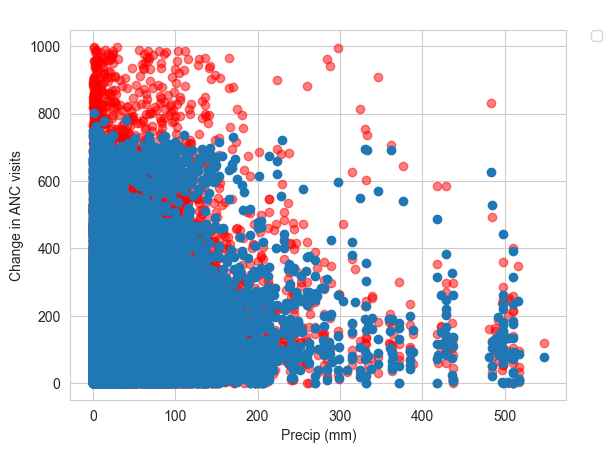

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


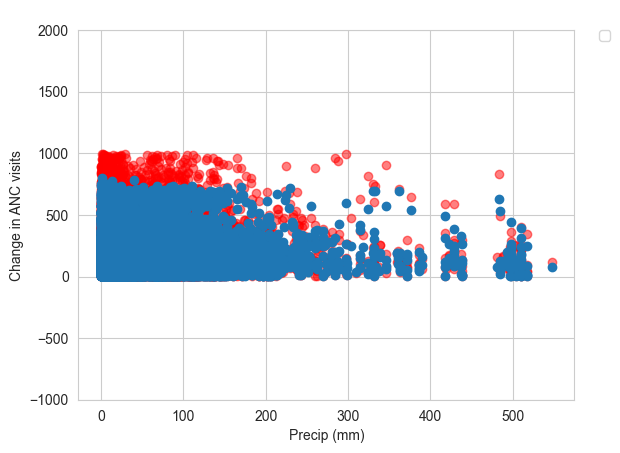

In [7]:
if use_residuals:
    y_weather = y[mask_ANC_data] - y_pred
    X = np.column_stack([
        weather_data[mask_ANC_data],
        np.array(year_flattened)[mask_ANC_data],
        #np.array(month_flattened)[mask_ANC_data],
        np.array(month_encoded)[mask_ANC_data],
        resid_encoded[mask_ANC_data],
        zone_encoded[mask_ANC_data],
        owner_encoded[mask_ANC_data],
        ftype_encoded[mask_ANC_data],
        facility_encoded[mask_ANC_data],
        lag_1_month[mask_ANC_data],
        lag_2_month[mask_ANC_data],
        lag_3_month[mask_ANC_data],
        lag_4_month[mask_ANC_data],
        np.array(altitude)[mask_ANC_data],
        np.array(minimum_distance)[mask_ANC_data]
    ])
else:
    y_weather = y 
    X = np.column_stack([
        weather_data,
        year_flattened,
        #month_flattened,
        month_encoded,
        resid_encoded,
        zone_encoded,
        owner_encoded,
        ftype_encoded,
        lag_1_month,
        lag_2_month,
        lag_3_month,
        lag_4_month,
        facility_encoded,
        np.array(altitude), 
        np.array(minimum_distance)
    ])

results_of_weather_model, y_pred_weather, mask_all_data = build_model(X, y_weather, poisson = poisson, log_y=log_y, X_mask_mm=mask_threshold)

print("All predictors", results_of_weather_model.summary())

##### Plot y_predic

X_filtered = X[mask_all_data]
print(y_pred_weather)
plt.scatter(X_filtered[:, 0], (y_weather[mask_all_data]), color='red', alpha=0.5)
if log_y:
    plt.scatter(X_filtered[:, 0], np.exp(y_pred_weather))
else:
    plt.scatter(X_filtered[:, 0], y_pred_weather)
plt.title(' ')
plt.ylabel('Change in ANC visits')
plt.xlabel('Precip (mm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


plt.scatter(X_filtered[:, 0], y_weather[mask_all_data], color='red', alpha=0.5)
if log_y:
    plt.scatter(X_filtered[:, 0], np.exp(y_pred_weather))
else:
    plt.scatter(X_filtered[:, 0], y_pred_weather)
plt.ylim((-1000,2000))
plt.title(' ')
plt.ylabel('Change in ANC visits')
plt.xlabel('Precip (mm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



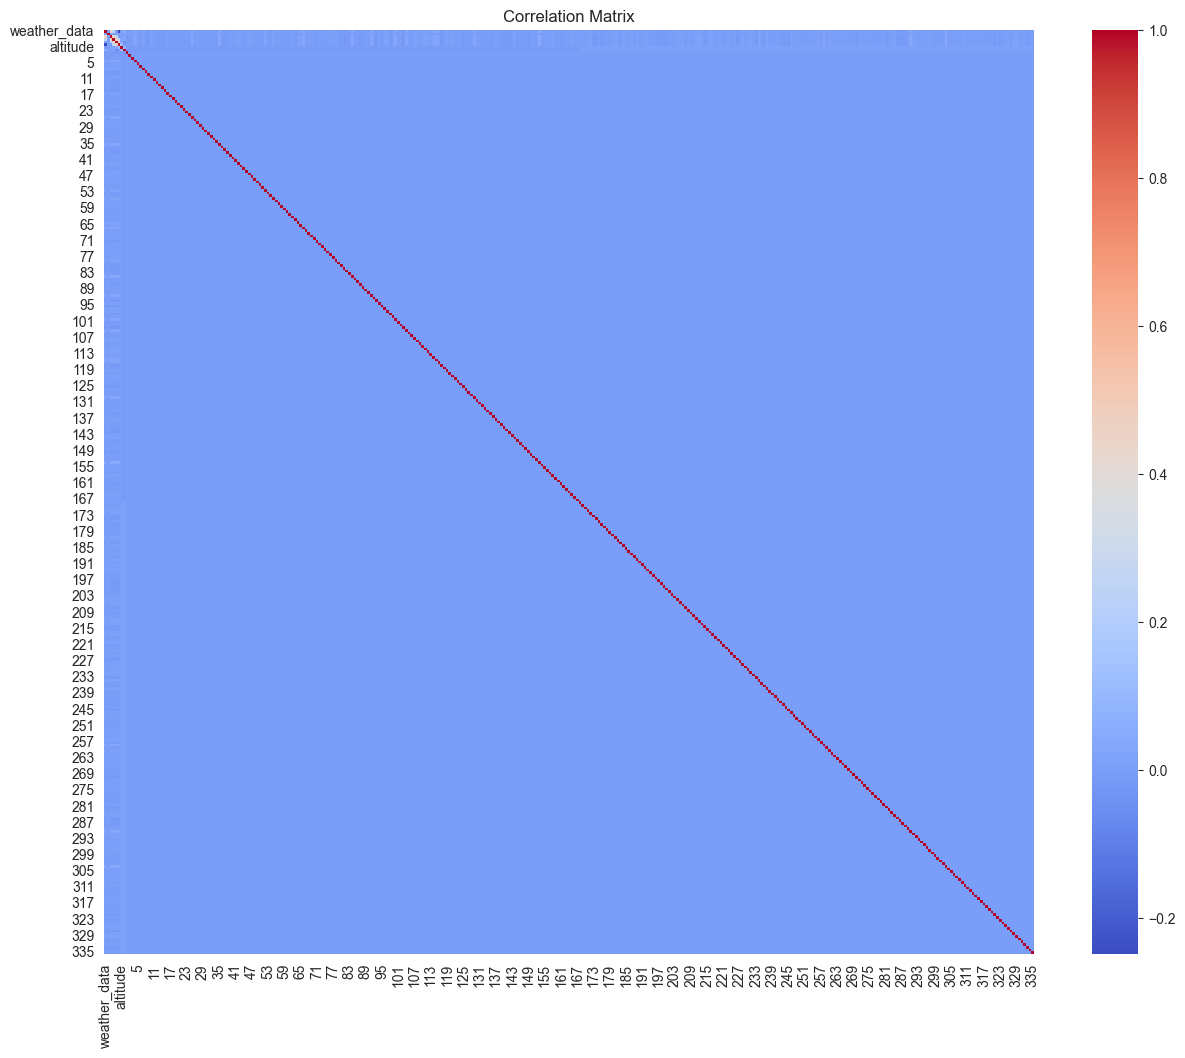

In [8]:
import seaborn as sns
data = {
    'weather_data': weather_data,
    'year_flattened': year_flattened,
    'lag_1_month': lag_1_month,
    'lag_2_month': lag_2_month,
    'lag_3_month': lag_3_month,
    'lag_4_month': lag_4_month,
    'altitude': np.array(altitude),
    'minimum_distance': np.array(minimum_distance)
}

df = pd.DataFrame(data)

# Concatenate one-hot encoded variables
df = pd.concat([df, facility_encoded], axis=1)

# Compute correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix (optional)
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.show()

/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_92649/1417594935.py:101: RuntimeWarning: overflow encountered in exp
  predictions = np.exp(y_pred_weather) - np.exp(y_pred_ANC[X_basis_weather[:,0] > mask_threshold])
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_92649/1417594935.py:101: RuntimeWarning: invalid value encountered in subtract
  predictions = np.exp(y_pred_weather) - np.exp(y_pred_ANC[X_basis_weather[:,0] > mask_threshold])
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_92649/1417594935.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(data_weather_predictions['Year_Month'], rotation=45, ha='right')


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 100 and the array at index 1 has size 1

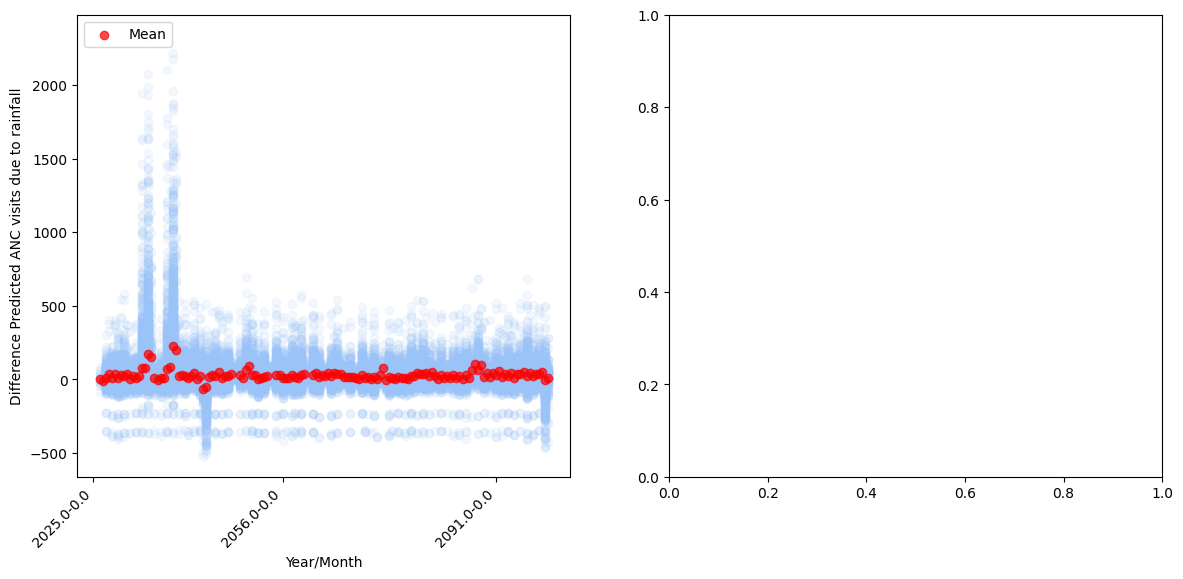

In [142]:

############### ADD IN CMIP DATA ###########################
def repeat_info(info, year_range):
    repeated_info = [i for i in info for _ in range(12) for _ in year_range]
    return repeated_info
# Configuration and constants
min_year_for_analysis = 2025
absolute_min_year = 2015
max_year_for_analysis = 2099
data_path = "/Users/rem76/Desktop/Climate_change_health/Data/"

# Load and preprocess weather data
weather_data_prediction = pd.read_csv(f"{data_path}Precipitation_data/ssp2_4_5/prediction_weather_by_smaller_facilities_with_ANC_lm.csv", index_col=0, dtype={'column_name': 'float64'})
weather_data_prediction = pd.read_csv(f"{data_path}Precipitation_data/ssp2_4_5/prediction_weather_monthly_by_smaller_facilities_with_ANC_lm.csv", index_col=0, dtype={'column_name': 'float64'})
weather_data_prediction = weather_data_prediction.iloc[(min_year_for_analysis - absolute_min_year) * 12:]
# Flatten data and prepare for regression
num_facilities = len(weather_data_prediction.columns)
year_range_prediction = range(min_year_for_analysis, max_year_for_analysis + 1)
month_repeated_prediction = [m for _ in year_range_prediction for m in range(1, 13)]
year_flattened_prediction = np.repeat(year_range_prediction, 12 * num_facilities)
month_flattened_prediction = month_repeated_prediction * num_facilities
month_encoded_prediction = pd.get_dummies(month_flattened_prediction, prefix='month', drop_first=True) # try one-hot-encode
facility_flattened_prediction = np.tile(range(num_facilities), len(year_flattened_prediction) // num_facilities)

# Encode facilities and create above/below average weather data
weather_data_prediction_flatten = weather_data_prediction.values.flatten()
facility_encoded_prediction = pd.get_dummies(facility_flattened_prediction, drop_first=True)

grouped_data = pd.DataFrame({
    'facility': facility_flattened_prediction,
    'month': month_flattened_prediction,
    'weather_data': weather_data_prediction_flatten
}).groupby(['facility', 'month'])['weather_data'].mean().reset_index()

# Load and preprocess facility information
info_file = "expanded_facility_info_by_smaller_facility_lm_with_ANC.csv" if ANC else "expanded_facility_info_by_smaller_facility_lm.csv"
expanded_facility_info = pd.read_csv(f"{data_path}{info_file}", index_col=0).T

zone_info_prediction = repeat_info(expanded_facility_info["Zonename"], year_range_prediction)
zone_encoded_prediction = pd.get_dummies(zone_info_prediction, drop_first=True)
resid_info_prediction = repeat_info(expanded_facility_info['Resid'], year_range_prediction)
resid_encoded_prediction = pd.get_dummies(resid_info_prediction, drop_first=True)
owner_info_prediction = repeat_info(expanded_facility_info['A105'], year_range_prediction)
owner_encoded_prediction = pd.get_dummies(owner_info_prediction, drop_first=True)
ftype_info_prediction = repeat_info(expanded_facility_info['Ftype'], year_range_prediction)
ftype_encoded_prediction = pd.get_dummies(ftype_info_prediction, drop_first=True)
altitude_prediction = [float(x) for x in repeat_info(expanded_facility_info['A109__Altitude'], year_range_prediction)]
minimum_distance_prediction = [float(x) for x in repeat_info(expanded_facility_info['minimum_distance'], year_range_prediction)]

# Lagged weather data
lag_1_month_prediction = weather_data_prediction.shift(1).values.flatten()
lag_2_month_prediction = weather_data_prediction.shift(2).values.flatten()
lag_3_month_prediction = weather_data_prediction.shift(3).values.flatten()
lag_4_month_prediction = weather_data_prediction.shift(4).values.flatten()

# Weather data

X_basis_weather = np.column_stack([
    weather_data_prediction_flatten,
    np.array(year_flattened_prediction),
    #np.array(month_flattened_prediction),
    np.array(month_encoded_prediction),
    resid_encoded_prediction,
    zone_encoded_prediction,
    owner_encoded_prediction,
    ftype_encoded_prediction,
    lag_1_month_prediction,
    lag_2_month_prediction,
    lag_3_month_prediction,
    lag_4_month_prediction,
    facility_encoded_prediction,
    altitude_prediction, 
    minimum_distance_prediction
])

X_basis_weather_filtered = X_basis_weather[X_basis_weather[:,0] > mask_threshold]
# format output 
year_month_labels = np.array([f"{y}-{m}" for y, m in zip(X_basis_weather_filtered[:,1], X_basis_weather[:,2])])
y_pred_weather = results_of_weather_model.predict(X_basis_weather_filtered)

if use_residuals:
    data_weather_predictions = pd.DataFrame({
    'Year_Month': year_month_labels,
    'difference': y_pred_weather
})
else:
    X_bases_ANC =  np.column_stack([
        year_flattened_prediction,
        #month_flattened_prediction,
        month_encoded_prediction,
        resid_encoded_prediction,
        zone_encoded_prediction,
        owner_encoded_prediction,
        ftype_encoded_prediction,
        facility_encoded_prediction, 
        altitude_prediction, 
        minimum_distance_prediction
        ])
    
    y_pred_ANC = results_ANC.predict(X_bases_ANC)
    if log_y:
        predictions = np.exp(y_pred_weather) - np.exp(y_pred_ANC[X_basis_weather[:,0] > mask_threshold])
    else:
        predictions = y_pred_weather - y_pred_ANC[X_basis_weather[:,0] > mask_threshold]

data_weather_predictions = pd.DataFrame({
    'Year_Month': year_month_labels,
    'difference': predictions, 
    'y_pred_ANC':y_pred_ANC[X_basis_weather[:,0] > mask_threshold], 
    'y_pred_weather':y_pred_weather
})
    
data_weather_predictions_grouped = data_weather_predictions.groupby('Year_Month').mean().reset_index()

# Plotting results
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].scatter(data_weather_predictions['Year_Month'], data_weather_predictions['difference'], color='#9AC4F8', alpha=0.1)
axs[0].scatter(data_weather_predictions_grouped['Year_Month'], data_weather_predictions_grouped['difference'], color='red', alpha=0.7, label='Mean')
axs[0].set_xticklabels(data_weather_predictions['Year_Month'], rotation=45, ha='right')
axs[0].set_xlabel('Year/Month')
xticks = data_weather_predictions['Year_Month'][::len(year_range)*12*num_facilities]  
axs[0].set_xticks(xticks)  
axs[0].set_xticklabels(xticks, rotation=45, ha='right')  
axs[0].set_ylabel('Difference Predicted ANC visits due to rainfall')
axs[0].legend(loc='upper left')
precipitation_range = np.linspace(X_basis_weather_filtered[:,0].min(), X_basis_weather_filtered[:,0].max(), 100)
X_for_line = np.column_stack([precipitation_range] + [np.mean(X_basis_weather_filtered[:, i]) for i in range(1, X_basis_weather_filtered.shape[1])])

y_line = results_of_weather_model.predict(X_for_line)

# Plotting
axs[1].scatter(X_basis_weather_filtered[:, 0], data_weather_predictions['difference'], color='#9AC4F8', alpha=0.7, label='Predictions')
axs[1].plot(precipitation_range, y_line, color='red', label='Line of Best Fit')  # Add line of best fit
axs[1].set_xlabel('Precipitation (mm)')
axs[1].set_ylabel('Expected number of ANC visits')
axs[1].legend()
# if log_y:
#         
#     axs[1].scatter(X_basis_weather_filtered[:,0], data_weather_predictions['difference'], color='#9AC4F8', alpha=0.7, label='Predictions')
#     axs[1].scatter(X_basis_weather_filtered[:,0],y_weather*results_of_weather_model.params[0],color='red')
# 
# else:
#         axs[1].scatter(X_basis_weather_filtered[:,0], data_weather_predictions['difference'], color='#9AC4F8', alpha=0.7, label='Predictions')
# 
#         axs[1].scatter(X_basis_weather_filtered[:,0],y_weather*results_of_weather_model.params[0],color='red')
# axs[1].set_xlabel('Precipitation (mm)')
# axs[1].set_ylabel('Expected number of ANC visits')

plt.tight_layout()
plt.show()


In [81]:
np.exp(y_weather*results_of_weather_model.params[0])

array([       nan,        nan,        nan, ..., 1.00129752, 1.00003705,
              nan])

# Machine learning 

In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np




In [10]:
def permutation_importances(rf, X_train, y_train, metric): 
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

In [11]:
param_grid = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "lbfgs"],
    "alpha": [0.0001, 0.001, 0.01],  # Regularization parameter
    "learning_rate": ["constant", "adaptive"],
    "max_iter": [500, 1000],
}


ANC case model 

In [32]:
y = monthly_reporting_by_facility.values.flatten()
if np.nanmin(y) < 1:
     y += 1  # Shift to ensure positivity as taking log
y[y > 4e3] = np.nan
log_y = False

In [116]:
if log_y:
    y = np.log(y)
    
X = np.column_stack([
    year_flattened,
    #month_flattened,
    month_encoded,
    resid_encoded,
    zone_encoded,
    owner_encoded,
    ftype_encoded,
    facility_encoded,
    altitude,
    np.array(minimum_distance)
])
mask_ANC = (~np.isnan(X).any(axis=1) & ~np.isnan(y) & (X[:, 0] >= mask_threshold) & (y <= 1e4))
X_masked = X[mask_ANC]
y_masked = y[mask_ANC]
X_train, X_test, y_train, y_test = train_test_split(X_masked, y_masked, test_size=0.2, random_state=42)
model = MLPRegressor(random_state=42)


/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_92649/1973427723.py:2: RuntimeWarning: invalid value encountered in log
  y = np.log(y)


In [117]:

# Feature Selection with Recursive Feature Elimination and Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,  
    scoring="neg_mean_squared_error",
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

# Pipeline with preprocessing, feature selection, and model fitting
pipeline_cases = Pipeline([
    ("feature_selection", SelectKBest(score_func=f_regression, k = 'all')),  
    ("model", random_search),
])
pipeline_cases.fit(X_train, y_train)
y_pred = pipeline_cases.predict(X_test)



Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/envs/tlo/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/tlo/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/tlo/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (sta

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, max_iter=500, solver=adam; total time=   8.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=500, solver=lbfgs; total time= 1.4min
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, max_iter=500, solver=adam; total time=   5.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, max_iter=500, solver=adam; total time=   4.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=500, solver=adam; total time=   2.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=500, solver=adam; total time=   4.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant, max_iter=500, solver=lbfgs; total time=  53.0s
[CV] END activation=tanh, alpha=0.00

/opt/anaconda3/envs/tlo/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/envs/tlo/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/tlo/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

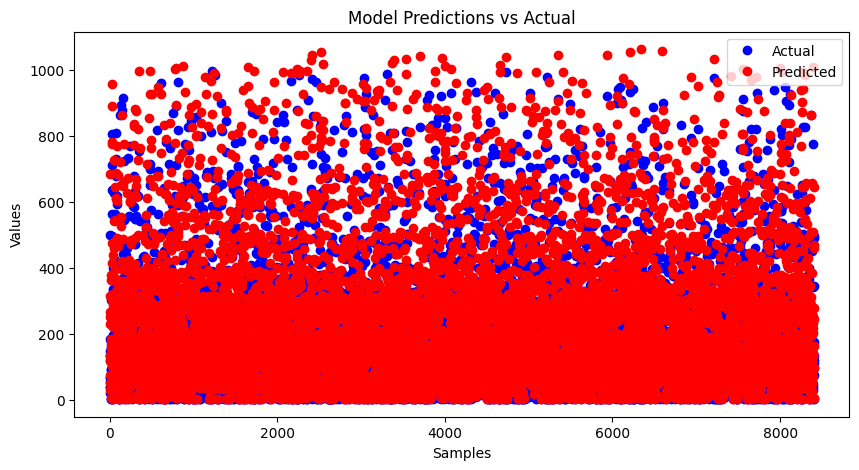

In [96]:
plt.figure(figsize=(10, 5))
if log_y:
    plt.plot(range(len(y_test)),np.exp(y_test), 'o',color="blue", label="Actual")
    plt.plot(range(len(y_pred)), np.exp(y_pred), 'o',color="red",   label="Predicted")
else:
    plt.plot(range(len(y_test)),y_test, 'o',color="blue", label="Actual")
    plt.plot(range(len(y_pred)), y_pred, 'o',color="red",   label="Predicted")
plt.title("Model Predictions vs Actual")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.legend()
plt.show()

In [97]:
train_indices = np.where(np.isin(y_train, y_masked))[0]
test_indices = np.where(np.isin(y_test,y_masked))[0]


Add in weather data

In [98]:
use_residuals

False

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/envs/tlo/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/tlo/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/tlo/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (sta

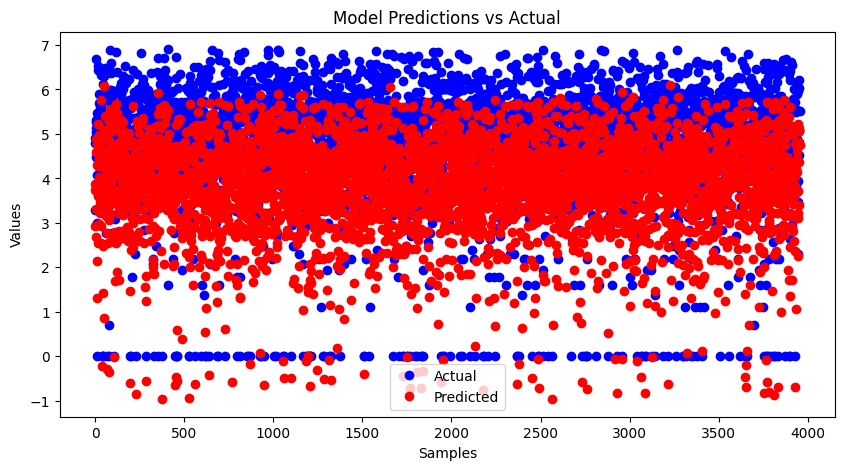

In [100]:

if use_residuals:
    y_weather = np.exp(y_test) - np.exp(y_pred)
    y_weather[np.isinf(y_weather)] = np.nan
    X_weather = np.column_stack([
        weather_data[mask_ANC],
        np.array(year_flattened)[mask_ANC],
        #np.array(month_flattened)[mask_ANC_data],
        np.array(month_encoded)[mask_ANC],
        resid_encoded[mask_ANC],
        zone_encoded[mask_ANC],
        owner_encoded[mask_ANC],
        ftype_encoded[mask_ANC],
        facility_encoded[mask_ANC],
        lag_1_month[mask_ANC],
        lag_2_month[mask_ANC],
        lag_3_month[mask_ANC],
        lag_4_month[mask_ANC],
        np.array(altitude)[mask_ANC],
        np.array(minimum_distance)[mask_ANC]
    ])
    X_weather = X_weather[test_indices,:]

else:
    y_weather = y
    y_weather[np.isinf(y_weather)] = np.nan
    X_weather = np.column_stack([
        weather_data,
        year_flattened,
        #month_flattened,
        month_encoded,
        resid_encoded,
        zone_encoded,
        owner_encoded,
        ftype_encoded,
        lag_1_month,
        lag_2_month,
        lag_3_month,
        lag_4_month,
        facility_encoded,
        np.array(altitude), 
        np.array(minimum_distance)
    ])

# Define the column index for weather_data in X_weather (assuming it's the first column)
weather_column_index = [0]  # Index 0 represents the first column in X_weather

preprocessor = ColumnTransformer(
    transformers=[
        ("weather_scaler", StandardScaler(), weather_column_index)  # Scale only the first column
    ],
    remainder="passthrough"  # Leave other columns as they are
)

mask_weather = (~np.isnan(X_weather).any(axis=1) & ~np.isnan(y_weather) & (X_weather[:, 0] >= mask_threshold) & (y_weather <= 1e4))
X_weather_masked = X_weather[mask_weather]
y_masked = y_weather[mask_weather]
X_weather_train, X_weather_test, y_weather_train, y_weather_test = train_test_split(X_weather_masked, y_masked, test_size=0.2, random_state=42)


# Feature Selection with Recursive Feature Elimination and Cross-Validation
cv_weather = KFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,  
    scoring="neg_mean_squared_error",
    cv=cv_weather,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
pipeline_weather = Pipeline([
    ("preprocessing", preprocessor),
    ("feature_selection", SelectKBest(score_func=f_regression, k='all')),  
    ("model", random_search)
])
pipeline_weather.fit(X_weather_train, y_weather_train)
y_weather_pred = pipeline_weather.predict(X_weather_test)

plt.figure(figsize=(10, 5))
plt.plot(range(len(y_weather_test)), y_weather_test, 'o',color="blue", label="Actual")
plt.plot(range(len(y_weather_pred)), y_weather_pred, 'o',color="red",   label="Predicted")
plt.title("Model Predictions vs Actual")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.legend()
plt.show()


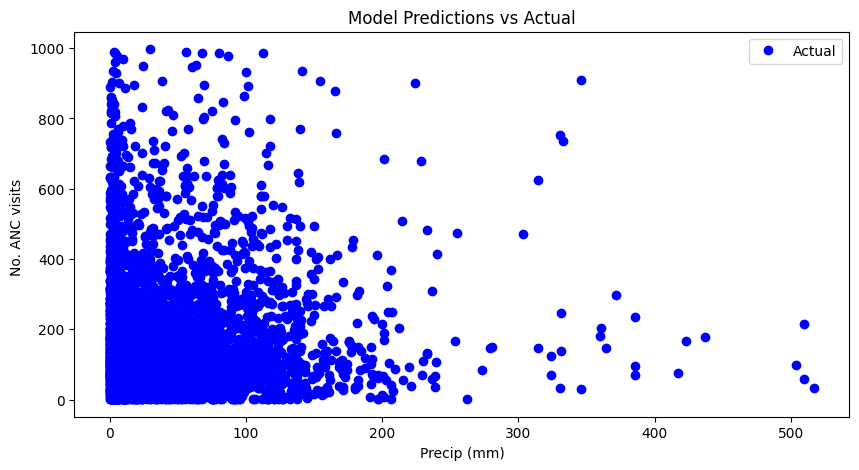

In [102]:
plt.figure(figsize=(10, 5))
plt.plot(X_weather_test[:,0], np.exp(y_weather_test), 'o',color="blue", label="Actual")
plt.title("Model Predictions vs Actual")
plt.xlabel("Precip (mm)")
plt.ylabel("No. ANC visits ")
plt.legend()
plt.show()

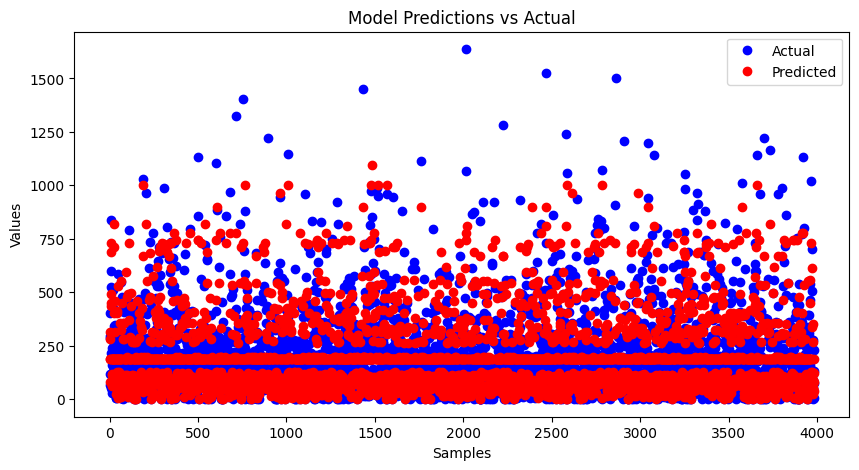

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_weather_test)), y_weather_test, 'o',color="blue", label="Actual")
plt.plot(range(len(y_weather_pred)), y_weather_pred, 'o',color="red",   label="Predicted")
plt.title("Model Predictions vs Actual")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.legend()
plt.show()

Masks


CMIP 6 data

/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_92649/1473954178.py:44: RuntimeWarning: overflow encountered in exp
  plt.plot(X_basis_weather_prediction_masked[:,0],(np.exp(y_weather_prediction_pred)  - np.exp(y_no_weather_prediction_pred)), 'o', color="blue", label="Difference")


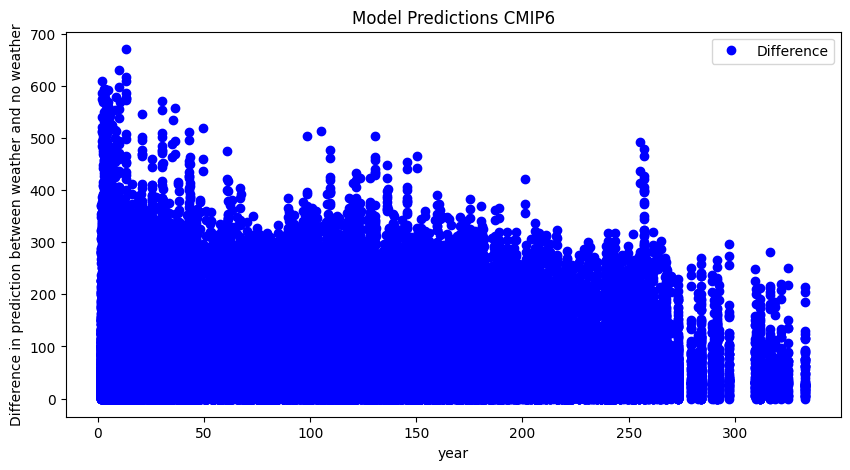

In [129]:
X_basis_weather_prediction = np.column_stack([
    weather_data_prediction_flatten,
    np.array(year_flattened_prediction),
    np.array(month_encoded_prediction),
    resid_encoded_prediction,
    zone_encoded_prediction,
    owner_encoded_prediction,
    ftype_encoded_prediction,
    lag_1_month_prediction,
    lag_2_month_prediction,
    lag_3_month_prediction,
    lag_4_month_prediction,
    facility_encoded_prediction,
    altitude_prediction, 
    minimum_distance_prediction
])

X_basis_prediction = np.column_stack([
    np.array(year_flattened_prediction),
    np.array(month_encoded_prediction),
    resid_encoded_prediction,
    zone_encoded_prediction,
    owner_encoded_prediction,
    ftype_encoded_prediction,

    facility_encoded_prediction,
    altitude_prediction, 
    minimum_distance_prediction
])

#X_basis_prediction_masked = X_basis_prediction[:, selected_features_mask]
#X_basis_weather_prediction_masked = X_basis_weather_prediction[:,selected_features_weather_mask]
#y_weather_prediction_pred = pipeline_weather.predict(X_basis_weather_prediction_masked)
#y_no_weather_prediction_pred = pipeline.predict(X_basis_prediction_masked)
mask_prediction = (~np.isnan(X_basis_weather_prediction).any(axis=1) & (X_basis_weather_prediction[:, 0] >= mask_threshold) & ~np.isnan(X_basis_prediction).any(axis=1) )

X_basis_prediction_masked = X_basis_prediction[mask_prediction,:]
X_basis_weather_prediction_masked = X_basis_weather_prediction[mask_prediction,:]

y_weather_prediction_pred = pipeline_weather.predict(X_basis_weather_prediction_masked)
y_no_weather_prediction_pred = pipeline_cases.predict(X_basis_prediction_masked)

plt.figure(figsize=(10, 5))
plt.plot(X_basis_weather_prediction_masked[:,0],(np.exp(y_weather_prediction_pred)  - np.exp(y_no_weather_prediction_pred)), 'o', color="blue", label="Difference")
# plt.plot(X_basis_weather_prediction_masked[:,0],np.exp(y_weather_prediction_pred), 'o', color="red", label="Predicted")
plt.title("Model Predictions CMIP6")
plt.xlabel("year")
plt.ylabel("Difference in prediction between weather and no weather")
plt.legend()
plt.show()



####### CROSS VALIDATION OF OLS REGRESSOR #####################

In [55]:

X_base_for_cross_validation_model1 = np.column_stack([
    year_flattened,
    #month_flattened,
    month_encoded,
    resid_encoded,
    zone_encoded,
    owner_encoded,
    ftype_encoded,
    facility_encoded,
    altitude, 
    minimum_distance
])

X_base_for_cross_validation_model2 = np.column_stack([
    year_flattened,
    month_encoded,
    resid_encoded,
    zone_encoded,
    owner_encoded,
    ftype_encoded,
    #facility_encoded,
    altitude, 
    minimum_distance
])

y_base_for_cross_validation = y

mask_for_cv = (~np.isnan(X_base_for_cross_validation_model1).any(axis=1) & ~np.isnan(y_base_for_cross_validation) & (y_base_for_cross_validation <= 1e4))
X_train_m1, X_test_m1, y_train_m1, y_test_m1 = train_test_split(X_base_for_cross_validation_model1[mask_for_cv,:], y_base_for_cross_validation[mask_for_cv], test_size=0.5)
X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(X_base_for_cross_validation_model2[mask_for_cv,:], y_base_for_cross_validation[mask_for_cv], test_size=0.5)


results_model1, y_pred_model1, mask_ANC_data_model1 = build_model(X_train_m1 , y_train_m1, poisson = poisson, log_y=log_y, X_mask_mm=mask_threshold)

results_model2, y_pred_model2, mask_ANC_data_model2 = build_model(X_train_m2 , y_train_m2, poisson = poisson, log_y=log_y, X_mask_mm=mask_threshold)


In [56]:
print("Model 1 Train", results_model1.rsquared)
print("Model 2 Train", results_model2.rsquared)


Model 1 Train 0.9770703294949092
Model 2 Train 0.9252845334223552


In [57]:
from sklearn.metrics import r2_score

In [58]:
y_test_pred1 = results_model1.predict(X_test_m1)
y_test_pred2 = results_model2.predict(X_test_m2)

In [59]:
print("Module 1 Test", r2_score(np.log(y_test_m1), y_test_pred1))
print("Module 2 Test", r2_score(np.log(y_test_m2), y_test_pred2))


Module 1 Test 0.6683064832148353
Module 2 Test 0.004429883540881807


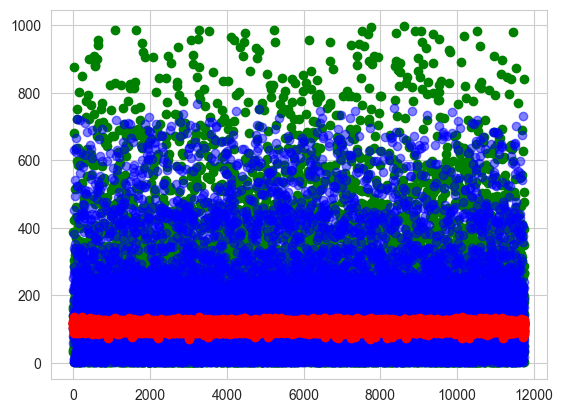

In [65]:
plt.plot(range(len(y_test_m2)), y_test_m2, 'o', color="green", label="Test set")
plt.plot(range(len(y_test_pred1)), np.exp(y_test_pred1), 'o', color="blue", label="Model 1", alpha=0.5)
plt.plot(range(len(y_test_pred2)), np.exp(y_test_pred2), 'o', color="red", label="Model 2")

In [76]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'penalty':['l1','l2','elasticnet','none'],
    'C' : np.logspace(-4,4,20),
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter'  : [100,1000,2500,5000]
}
]
model_1_LR = LogisticRegression().fit(X_train_m1, y_train_m1)

clf = GridSearchCV(model_1_LR,param_grid = param_grid, cv = 3, verbose=True,n_jobs=-1)

clf.fit(X_train_m1, y_train_m1)
PI_model_1 = permutation_importance(clf, X_test_m1, y_test_m1,
                           n_repeats=30,
                           random_state=0)

for i in PI_model_1.importances_mean.argsort()[::-1]:
    if PI_model_1.importances_mean[i] - 2 * PI_model_1.importances_std[i] > 0:
        print(f"{X_base_for_cross_validation_model1.columns[i]:<8}"
              f"{PI_model_1.importances_mean[i]:.3f}"
              f" +/- {PI_model_1.importances_std[i]:.3f}")

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


/opt/anaconda3/envs/tlo/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/tlo/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/opt/anaconda3/envs/tlo/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 

KeyboardInterrupt: 

In [74]:
    PI_model_1

{'importances_mean': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

# Now weather

In [72]:

X_base_for_cross_validation_weather_model1 = np.column_stack([
    weather_data,
    year_flattened,
    #month_flattened,
    month_encoded,
    resid_encoded,
    zone_encoded,
    owner_encoded,
    ftype_encoded,
    facility_encoded,
    altitude, 
    minimum_distance
])

X_base_for_cross_validation_weather_model2 = np.column_stack([
    weather_data,
    year_flattened,
    month_encoded,
    resid_encoded,
    zone_encoded,
    owner_encoded,
    ftype_encoded,
    #facility_encoded,
    altitude, 
    minimum_distance
])

y_base_for_cross_validation_weather = y

mask_for_cv_weather = (~np.isnan(X_base_for_cross_validation_weather_model1).any(axis=1) & ~np.isnan(y_base_for_cross_validation_weather) & (y_base_for_cross_validation_weather <= 1e4))

X_train_m1_weather, X_test_m1_weather, y_train_m1_weather, y_test_m1_weather = train_test_split(X_base_for_cross_validation_weather_model1[mask_for_cv_weather,:], y_base_for_cross_validation_weather[mask_for_cv_weather], test_size=0.5)

X_train_m2_weather, X_test_m2_weather, y_train_m2_weather, y_test_m2_weather = train_test_split(X_base_for_cross_validation_weather_model2[mask_for_cv_weather,:], y_base_for_cross_validation_weather[mask_for_cv_weather], test_size=0.5)


results_model1_weather, y_pred_model1_weather, mask_ANC_data_model1_weather = build_model(X_train_m1_weather , y_train_m1_weather, poisson = poisson, log_y=log_y, X_mask_mm=mask_threshold)

results_model2_weather, y_pred_model2_weather, mask_ANC_data_model2_weather = build_model(X_train_m2_weather , y_train_m2_weather, poisson = poisson, log_y=log_y, X_mask_mm=mask_threshold)

print("Model 1 Train", results_model1_weather.rsquared)
print("Model 2 Train", results_model2_weather.rsquared)

y_test_pred1_weather = results_model1_weather.predict(X_test_m1_weather)
y_test_pred2_weather = results_model2_weather.predict(X_test_m2_weather)

print("Module 1 Test", r2_score(np.log(y_test_m1_weather), y_test_pred1_weather))
print("Module 2 Test", r2_score(np.log(y_test_m2_weather), y_test_pred2_weather))

Model 1 Train 0.9765587980092865
Model 2 Train 0.9269536425397121
Module 1 Test 0.663155638367235
Module 2 Test -0.0003346727400466154


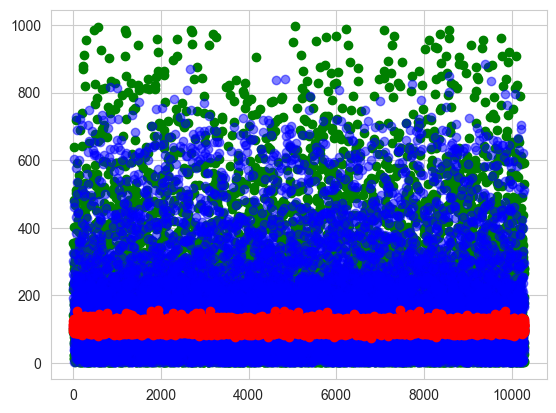

In [73]:
plt.plot(range(len(y_test_m2_weather)), y_test_m2_weather, 'o', color="green", label="Test set")
plt.plot(range(len(y_test_pred1_weather)), np.exp(y_test_pred1_weather), 'o', color="blue", label="Model 1", alpha=0.5)
plt.plot(range(len(y_test_pred2_weather)), np.exp(y_test_pred2_weather), 'o', color="red", label="Model 2")